# 一維頻譜分析

本頁面示範如何利用Python建立NCL Spectral Analysis 一維頻譜分析的工具。(本頁面程式碼由Google Gemini產生)

首先建立以下自定義函式：

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import chi2

def specx_anal(data, d, sm, pct):
    """
    Python 版本的 NCL specx_anal 函數。
    計算平滑後的一維頻譜 (power spectrum)。
    
    輸入參數:
    - data: 輸入的一維時間序列 (numpy array)
    - d: detrend 選項 (0: 減去平均值, 1: 線性去趨勢)
    - sm: 平滑窗區 (window) 大小 (奇數)
    - pct: 資料兩端的 tapering 百分比
    
    返回:
    - spec_info: 一個包含頻譜分析結果的dictionary
    """
    n = len(data)
    
    # Linear detrend
    detrend_type = 'constant' if d == 0 else 'linear'
    
    # Tapering (加窗)
    window = signal.windows.tukey(n, alpha=2*pct)
    
    # 計算週期圖 (Periodogram)
    # fs=1 代表取樣頻率為每月一次，
    # scaling='density' 會得到頻譜密度 (Power Spectral Density, PSD)
    # 這一步驟整合了加窗、去趨勢、FFT 和計算單邊頻譜
    freqs, pxx_raw = signal.periodogram(
        data, fs=1, window=window, detrend=detrend_type, scaling='density'
    )
    
    # 平滑頻譜：使用convolution進行滑動平均
    smoother = np.ones(sm) / sm
    pxx_smooth = np.convolve(pxx_raw, smoother, mode='same')
    
    # 5. 計算等效自由度 (Degrees of Freedom) 和頻寬 (Bandwidth)。請參考NCL網站說明。
    dof = 2 * sm
    bw = dof / n  # 假設 dt=1
    
    spec_info = {
        'spcx': pxx_smooth,
        'frq': freqs,
        'dof': dof,
        'bw': bw
    }
    return spec_info

def specx_ci(original_data, spec_info, clevel_lower, clevel_upper):
    """
    Python 版本的 NCL specx_ci 函數。
    計算基於紅噪音 (AR1 過程) 的信賴區間。
    
    回傳:
    - splt: 一個 (4, n_freqs) 的 array，包含:
            [0]: 平滑後的數據頻譜
            [1]: 理論紅噪音頻譜
            [2]: 紅噪音的信賴界線下邊界
            [3]: 紅噪音的信賴界線上邊界
    """
    # 從 spec_info 字典中取出所需變量
    spcx = spec_info['spcx']
    freqs = spec_info['frq']
    dof = spec_info['dof']
    
    n_freqs = len(freqs)

    # 使用原始資料來計算 lag-1 自相關係數 (r1)
    mean_data = original_data.mean()
    anom_data = original_data - mean_data
    r1 = np.corrcoef(anom_data[:-1], anom_data[1:])[0, 1]

    # 計算理論紅噪音頻譜。使用 Gilman et al. (1963) 的公式
    red_noise_spec = (1 - r1**2) / (1 - 2 * r1 * np.cos(2 * np.pi * freqs) + r1**2)
    
    # 將紅噪音頻譜的總變異數 variance 調整為與資料頻譜相同，確保兩者在同一尺度上進行比較
    red_noise_spec_normalized = red_noise_spec * (np.sum(spcx) / np.sum(red_noise_spec))
    
    # 根據卡方分佈 (Chi-squared distribution) 計算信賴區間 
    chi2_lower = chi2.ppf(clevel_lower, dof)
    chi2_upper = chi2.ppf(clevel_upper, dof)
    
    lower_bound = red_noise_spec_normalized * (chi2_lower / dof)
    upper_bound = red_noise_spec_normalized * (chi2_upper / dof)
    
    # 回傳結果
    splt = np.vstack([spcx, red_noise_spec_normalized, lower_bound, upper_bound])
    
    return splt

我們以南方震盪指標 SOI (Southern Oscillation Index) 資料為例，示範如何使用上述函式進行頻譜分析。

In [2]:
ds = xr.open_dataset("./data/SOI_Darwin.nc")
soi_data = ds['DSOI'].values

# 設定函數參數
d = 0      # 去趨勢選項: 0=>移除平均值
sm = 21    # 平滑窗區: 至少為 3 的奇數
pct = 0.10 # Tapering 百分比

# 計算頻譜
sdof = specx_anal(soi_data, d, sm, pct)

# 計算信賴區間 (5% 和 95%)
splt = specx_ci(soi_data,sdof, 0.05, 0.95)

繪圖

Lag-1 autocorrelation (r1): 0.5348


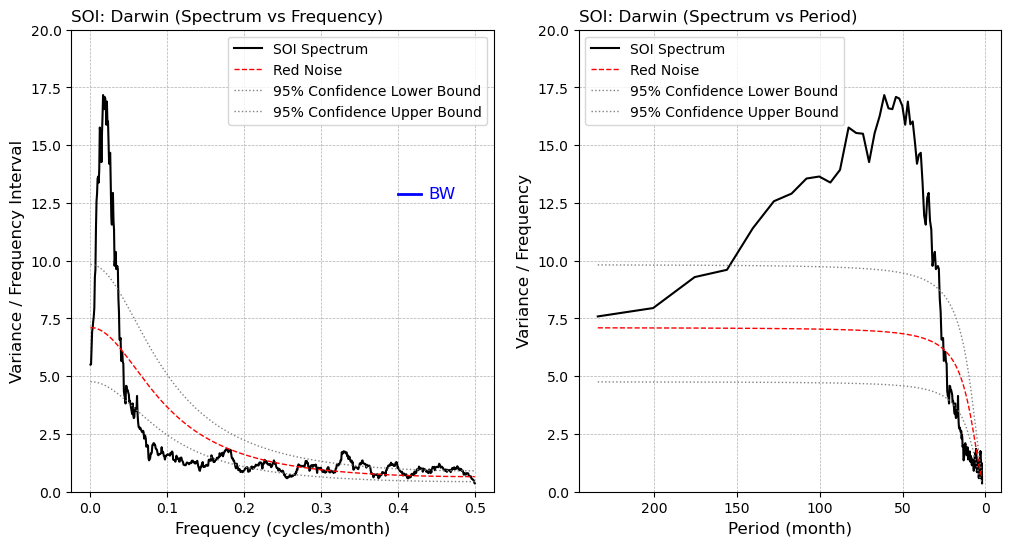

In [5]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))
ax=axes.flatten()

# (a) x軸設為頻率
ax[0].plot(sdof['frq'], splt[0,:], label='SOI Spectrum', color='black', lw=1.5)
ax[0].plot(sdof['frq'], splt[1,:], label='Red Noise', color='red', lw=1.0, linestyle='--')
ax[0].plot(sdof['frq'], splt[2,:], label='95% Confidence Lower Bound', color='gray', lw=1.0, linestyle=':')
ax[0].plot(sdof['frq'], splt[3,:], label='95% Confidence Upper Bound', color='gray', lw=1.0, linestyle=':')

ax[0].set_title("SOI: Darwin (Spectrum vs Frequency)", loc='left')
ax[0].set_xlabel("Frequency (cycles/month)", fontsize=12)
ax[0].set_ylabel("Variance / Frequency Interval", fontsize=12)
ax[0].set_ylim(0.0, 20.0) 
ax[0].grid(True, which="major", ls="--", linewidth=0.5)
ax[0].legend()

# 繪製頻寬 (Bandwidth)
bw_x = [0.40, 0.40 + sdof['bw']]
bw_y_val = 0.75 * np.max(sdof['spcx'])
bw_y = [bw_y_val, bw_y_val]
ax[0].plot(bw_x, bw_y, color='blue', lw=2)
ax[0].text(0.41 + sdof['bw'], bw_y_val, "BW", color='blue', va='center', ha='left', fontsize=12)

# (b) x軸為週期
#將頻率轉換為週期
freqs_nonzero = sdof['frq'][1:]
splt_nonzero = splt[:, 1:]
period = 1 / freqs_nonzero

ip = period <= 240 # 只繪製週期小於等於240個月的部分

ax[1].plot(period[ip], splt_nonzero[0, ip], label='SOI Spectrum', color='black', lw=1.5)
ax[1].plot(period[ip], splt_nonzero[1, ip], label='Red Noise', color='red', lw=1.0, linestyle='--')
ax[1].plot(period[ip], splt_nonzero[2, ip], label='95% Confidence Lower Bound', color='gray', lw=1.0, linestyle=':')
ax[1].plot(period[ip], splt_nonzero[3, ip], label='95% Confidence Upper Bound', color='gray', lw=1.0, linestyle=':')

ax[1].set_title("SOI: Darwin (Spectrum vs Period)", loc='left')
ax[1].set_xlabel("Period (month)", fontsize=12)
ax[1].set_ylabel("Variance / Frequency", fontsize=12)
ax[1].set_ylim(0.0, 20.0)
ax[1].grid(True, which="major", ls="--", linewidth=0.5)
ax[1].legend()

ax[1].invert_xaxis()

print(f"Lag-1 autocorrelation (r1): {np.corrcoef(soi_data[:-1], soi_data[1:])[0, 1]:.4f}")